# Topic 2: Predict Student Performance from Game Play

**Session 1: Exploratory Data Analysis**

## Context

The goal is to predict student performance during game-based learning in real-time, where the training are game logs.

For each `<session_id>`_`<question no.>`, I am predicting the `correct` column, identifying whether it is believed that the user for this particular session will answer this question correctly only using the previous information for the session.

## Files

- **train.csv** - the training set
- **test.csv** - the test set
- **sample_submission.csv** - a sample submission file in the correct format
- **train_labels.csv** - `correct` value for all 18 questions for each session in the training set

## Columns in training set

- **session_id** - The ID of the session the event took place in
- **index** - The index of the event for the session
- **elapsed_time** - How much time has passed (in ms) between the start of the session and when the event was recorded
- **event_name** - The name of the event type
- **name** - The event name (e.g., identifies whether a notebook_click is opening or closing the notebook)
- **level** - What level of the game the event occurred (0 to 22)
- **page** - The page number of the event (only for notebook-related event)
- **room_coor_x** - The Ox coordinates of the click in reference to the in-game room (only for click events)
- **room_coor_y** - The Oy coordinates of the click in reference to the in-game room (only for click events)
- **screen_coor_x** - The Ox coordinates of the click in reference to the player's screen (only for click events)
- **screen_coor_y** - The Oy coordinates of the click in reference to the player's screen (only for click events)
- **hover_duration** - How long (in ms) the hover happened for (only for hover events)
- **text** - The text the player sees during the event
- **fqid** - The fully qualified ID of the event
- **room_fqid** - The fully qualified ID of the room the event took place in
- **text_fqid** - The fully qualified ID of the text
- **fullscreen** - Whether the player is in fullscreen mode
- **hq** - Whether the player is in high-quality
- **music** - Whether the game music is on or off
- **level_group** - Which group of levels & questions the record belongs to (0-4, 5-12, 13-22)

In [69]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer, f1_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV

In [13]:
# Load the dataset
dtypes = {
    'elapsed_time': np.int32,
    'event_name': 'category', 
    'name': 'category',
    'level': 'category',
    'room_coor_x': np.float32,
    'room_coor_y': np.float32,
    'screen_coor_x': np.float32,
    'screen_coor_y': np.float32,
    'hover_duration': np.float32,
    'text': 'category',
    'fqid': 'category',
    'room_fqid': 'category',
    'text_fqid': 'category',
    'fullscreen': 'category',
    'hq': 'category',
    'music': 'category',
    'level_group': 'category'
}

df = pd.read_csv('data/train.csv', dtype=dtypes)

# Print the first 5 rows
df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [14]:
# Shape of the dataset
df.shape

(26296946, 20)

In [15]:
# Number of sessions
df['session_id'].nunique()

23562

In [16]:
label_df = pd.read_csv('data/train_labels.csv')
label_df.head()

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [17]:
label_df.shape

(424116, 2)

In [18]:
label_df['session'] = label_df.session_id.apply(lambda x: int(x.split('_')[0]) )
label_df['question_idx'] = label_df.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
label_df.drop("session_id", axis=1, inplace=True)

In [19]:
label_df.head()

,correct,session,question_idx
0,1,20090312431273200,1
1,0,20090312433251036,1
2,1,20090312455206810,1
3,0,20090313091715820,1
4,1,20090313571836404,1


In [20]:
label_df['question_idx'].value_counts().T

1     23562
2     23562
17    23562
16    23562
15    23562
14    23562
13    23562
12    23562
11    23562
10    23562
9     23562
8     23562
7     23562
6     23562
5     23562
4     23562
3     23562
18    23562
Name: question_idx, dtype: int64

- Every session contains 18 questions and the student is told to do all the 18 questions, despite the level it falls into.

In [55]:
label_df = pd.read_csv('data/train_labels.csv')
label_df['session'] = label_df.session_id.apply(lambda x: int(x.split('_')[0]) )
label_df['question_idx'] = label_df.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
label_df.drop("session_id", axis=1, inplace=True)
pivoted_questions = label_df.pivot(columns='question_idx', values='correct', index='session')
# pivoted_questions['total_score'] = pivoted_questions.iloc[:, 0:18].sum(axis=1)
# pivoted_questions.columns = [f'q_{i}' for i in range(1, 19)] + ['total_score']
pivoted_questions

question_idx,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
session,,,,,,,,,,,,,,,,,,
20090312431273200,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
20090312433251036,0,1,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1
20090312455206810,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
20090313091715820,0,1,1,1,1,0,1,1,1,0,0,1,0,1,0,1,1,1
20090313571836404,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1
22100215460321130,0,1,1,1,0,1,1,0,1,0,1,1,0,1,0,1,1,1
22100217104993650,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,1


- Later on, we will use this table to join with training table in order to perform further analysis

In [22]:
# Observe the unique values in some categorical columns
for col in df.select_dtypes('category'):
    nunique = df[col].nunique()
    last_20_unique_list = df[col].unique().tolist()[:20]
    print(f'{col :-<50} ({nunique}) {last_20_unique_list}')

event_name---------------------------------------- (11) ['cutscene_click', 'person_click', 'navigate_click', 'observation_click', 'notification_click', 'object_click', 'object_hover', 'map_hover', 'map_click', 'checkpoint', 'notebook_click']
name---------------------------------------------- (6) ['basic', 'undefined', 'close', 'open', 'prev', 'next']
level--------------------------------------------- (23) ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
text---------------------------------------------- (597) ['undefined', 'Whatcha doing over there, Jo?', 'Just talking to Teddy.', 'I gotta run to my meeting!', 'Can I come, Gramps?', 'Sure thing, Jo. Grab your notebook and come upstairs!', 'See you later, Teddy.', "I get to go to Gramps's meeting!", 'Now where did I put my notebook?', '\\u00f0\\u0178\\u02dc\\u00b4', nan, 'I love these photos of me and Teddy!', 'Found it!', 'Gramps is in trouble for losing papers?', "This can'

## Analyzing a single session

In [24]:
# Examine 1 specific session
session_1_df = df[df['session_id'] == 20090312431273200]

In [25]:
session_1_df = session_1_df.sort_values('elapsed_time')
session_1_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


Some features that are in thought of being featured:

- **time_diff**: Time difference between 2 consecutive actions, showing the focus/distraction of student. This can be created by differencing the `elapsed_time` between 2 closest action. However, since the increment of elapsed time does not depend on the index order, we may need to reorder it. This is only a support feature for the other ones to be computed.
- **event_count**: How many time does an event occurred? We may assume that there exists every action that are highly correlated to the performance. In other word, student that did more (or less) of a specific action may get a higher score.
- **action_count_on_level**, **action_count_on_level_group**: The number of actions taken on a specific level/level group.
- **time_spent_on_level**, **time_spent_on_level_group**: The amount of time that student spend on a specific level/level group. It may indicate which level/level group is more efficient for learning.
- **clicking_distance**: The distance of the mouse between 2 consecutive clicks. We may assume the case that students clicking out things ambiguously would get lower score.
- **average_hover_duration**: Average of `hover_duration`.
- **full_screen_time**, **full_screen_proportion**: The amount of time/time proportion over the whole session that students open full screen for fully focus on the game.
- **hq_on_time**, **hq_on_proportion**: The amount of time/time proportion over the whole session that students use high quality mode.
- **music_on_time**, **music_on_proportion**: The amount of time/time proportion over the whole session that students use background music. Observing does background music is a distraction or an encouragement for learning.

In [60]:
def feature_extraction_over_single_session(session_df):
    session_info_dict = {}
    
    session_df['time_diff'] = session_df['elapsed_time'].diff(1).fillna(0)
    
    event_name = [
        'cutscene_click',
        'person_click',
        'navigate_click',
        'observation_click',
        'notification_click',
        'object_click',
        'object_hover',
        'map_hover',
        'map_click',
        'checkpoint',
        'notebook_click'
    ]
    event_count = session_df.groupby('event_name')['event_name'].count().to_dict()
    session_info_dict.update({f'{i}_count': event_count.get(i, 0) for i in event_name})
    
    level_stats = session_df.groupby(['level']).size()
    print(level_stats)
    session_info_dict.update({f'action_count_on_level_{i}': level_stats.get(i, 0) for i in range(23)})
    
    level_group_stats = session_df.groupby(['level_group']).size()
    session_info_dict.update({f'action_count_on_level_group_{i}': level_group_stats.get(i, 0) for i in ['0-4', '5-12', '13-22']})
    
    time_spent_level_stats = session_df.groupby(['level'])['time_diff'].sum()
    print(time_spent_level_stats)
    session_info_dict.update({f'time_spent_on_level_{i}': time_spent_level_stats.get(i, 0) for i in range(23)})
    
    time_spent_level_group_stats = session_df.groupby(['level_group'])['time_diff'].sum()
    session_info_dict.update({f'time_spent_on_level_group_{i}': time_spent_level_group_stats.get(i, 0) for i in ['0-4', '5-12', '13-22']})
    
    coordinates = session_df[['room_coor_x', 'room_coor_y']].copy()
    coordinates.dropna(inplace=True)
    clicking_x_diff = coordinates['room_coor_x'].diff(1).fillna(0)
    clicking_y_diff = coordinates['room_coor_y'].diff(1).fillna(0)
    distance_diff = (clicking_x_diff - clicking_y_diff) ** 2
    mean_distance_diff = distance_diff.mean()
    session_info_dict.update({'average_clicking_distance': mean_distance_diff})
    session_info_dict.update({'average_hover_duration': session_df['hover_duration'].mean()})
    
    session_total_time = session_df['elapsed_time'].max()

    full_screen_time = (session_df['time_diff'] * session_df['fullscreen'].astype('int')).mean()
    full_screen_proportion = full_screen_time / session_total_time
    hq_on_time = (session_df['time_diff'] * session_df['hq'].astype('int')).mean()
    hq_on_proportion = hq_on_time / session_total_time
    music_on_time = (session_df['time_diff'] * session_df['music'].astype('int')).mean()
    music_on_proportion = music_on_time / session_total_time

    session_info_dict.update({
        'full_screen_time': full_screen_time,
        'full_screen_proportion': full_screen_proportion,
        'hq_on_time': hq_on_time,
        'hq_on_proportion': hq_on_proportion,
        'music_on_time': music_on_time,
        'music_on_proportion': music_on_proportion
    })
    
    return pd.Series(session_info_dict).fillna(0)

In [61]:
feature_extraction_over_single_session(session_1_df).to_frame()

,0
cutscene_click,100.000000
person_click,249.000000
navigate_click,354.000000
observation_click,8.000000
notification_click,27.000000
object_click,59.000000
object_hover,38.000000
map_hover,27.000000
map_click,16.000000
checkpoint,3.000000


In [62]:
df_agg = df.groupby('session_id').apply(feature_extraction_over_single_session)
df_agg.head()

,cutscene_click,person_click,navigate_click,observation_click,notification_click,object_click,object_hover,map_hover,map_click,checkpoint,...,time_spent_on_level_group_5-12,time_spent_on_level_group_13-22,average_clicking_distance,average_hover_duration,full_screen_time,full_screen_proportion,hq_on_time,hq_on_proportion,music_on_time,music_on_proportion
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,100.0,249.0,354.0,8.0,27.0,59.0,38.0,27.0,16.0,3.0,...,304375.0,773444.0,66856.742188,1115.292358,0.000000,0.000000,0.000000,0.000000,1444.584563,0.001135
20090312433251036,112.0,260.0,801.0,10.0,28.0,172.0,103.0,219.0,64.0,3.0,...,583857.0,2997725.0,87125.671875,756.711182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20090312455206810,120.0,215.0,247.0,4.0,24.0,40.0,24.0,30.0,19.0,3.0,...,269634.0,556190.0,83770.039062,1040.351807,1568.667546,0.001319,1568.667546,0.001319,1568.667546,0.001319
20090313091715820,112.0,234.0,416.0,10.0,28.0,79.0,45.0,39.0,18.0,3.0,...,556059.0,872516.0,58957.773438,1327.488037,1632.797583,0.001007,1632.797583,0.001007,1632.797583,0.001007
20090313571836404,92.0,222.0,279.0,8.0,25.0,42.0,31.0,15.0,18.0,3.0,...,331766.0,647059.0,90386.085938,1435.521729,0.000000,0.000000,0.000000,0.000000,1574.632708,0.001340


In [63]:
pd.set_option('display.max_rows', 100)
df_agg.describe().T

,count,mean,std,min,25%,50%,75%,max
cutscene_click,23562.0,1.147201e+02,1.585706e+01,6.700000e+01,103.000000,1.140000e+02,1.220000e+02,4.830000e+02
person_click,23562.0,2.568905e+02,3.509667e+01,2.000000e+02,229.000000,2.570000e+02,2.740000e+02,9.170000e+02
navigate_click,23562.0,4.807076e+02,2.479432e+02,1.620000e+02,329.000000,4.180000e+02,5.560000e+02,1.149300e+04
observation_click,23562.0,9.012605e+00,3.726604e+00,3.000000e+00,6.000000,8.000000e+00,1.100000e+01,7.800000e+01
notification_click,23562.0,2.754439e+01,5.146667e+00,2.000000e+01,24.000000,2.600000e+01,3.000000e+01,1.140000e+02
object_click,23562.0,9.329475e+01,6.289893e+01,3.200000e+01,57.000000,7.500000e+01,1.080000e+02,3.045000e+03
object_hover,23562.0,4.486398e+01,2.039814e+01,0.000000e+00,35.000000,4.400000e+01,5.500000e+01,2.320000e+02
map_hover,23562.0,4.011370e+01,2.897315e+01,0.000000e+00,24.000000,3.400000e+01,5.000000e+01,4.720000e+02
map_click,23562.0,2.195238e+01,1.058088e+01,1.300000e+01,16.000000,1.900000e+01,2.400000e+01,7.530000e+02
checkpoint,23562.0,3.014515e+00,1.889341e-01,2.000000e+00,3.000000,3.000000e+00,3.000000e+00,9.000000e+00


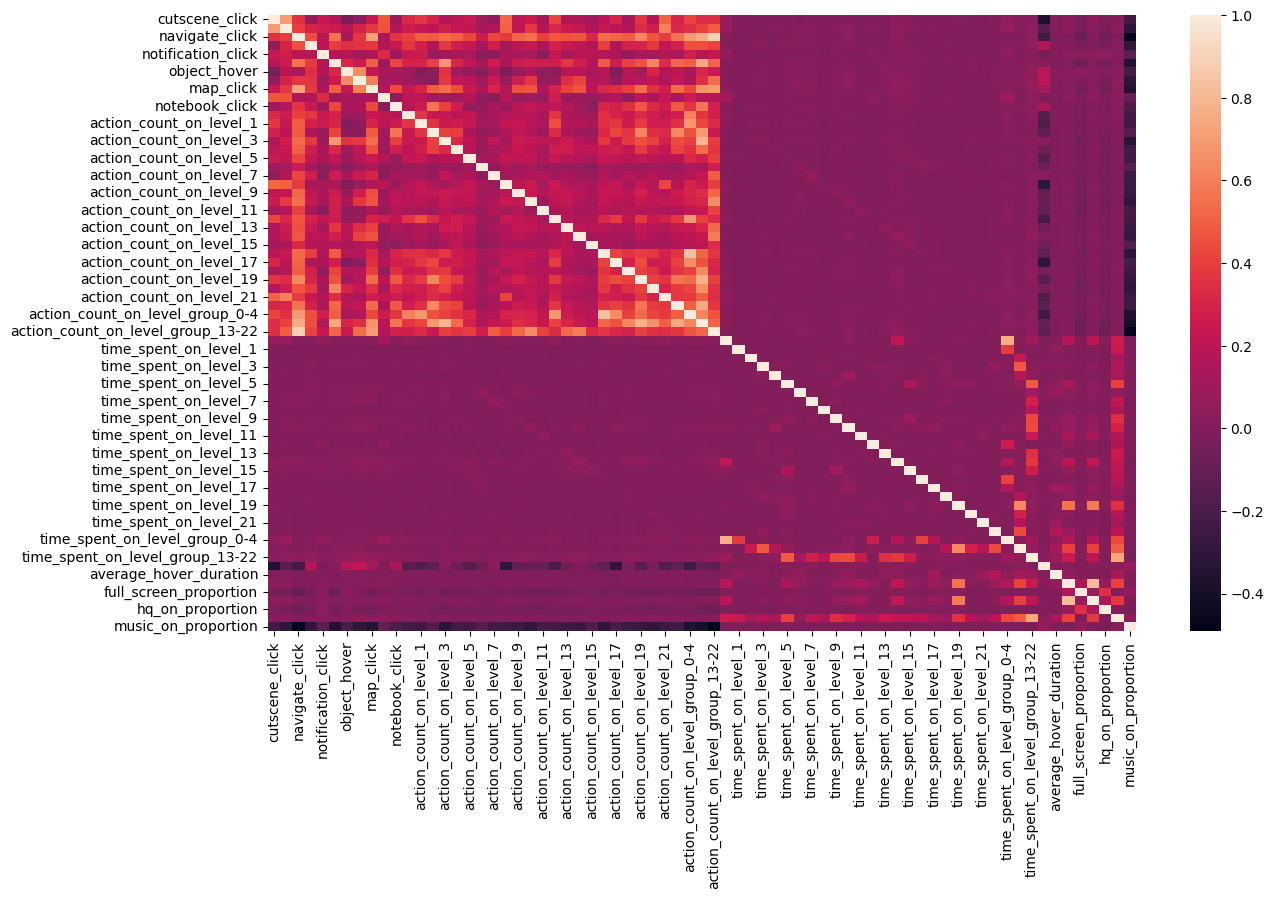

In [64]:
plt.figure(figsize=(14,8))
sns.heatmap(df_agg.corr())
plt.show()

In [65]:
X = df_agg.values
y = pivoted_questions.values
X.shape, y.shape

((23562, 71), (23562, 18))

In [77]:
# Choose the type of classifier 
rf = RandomForestClassifier()
rf.fit(X, y)
y_pred = rf.predict(X)

[[1 1 1 ... 0 1 1]
 [0 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 1 1]]
[[1 1 1 ... 0 1 1]
 [0 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 1 1]]


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    124845
           1     1.0000    1.0000    1.0000    299271

    accuracy                         1.0000    424116
   macro avg     1.0000    1.0000    1.0000    424116
weighted avg     1.0000    1.0000    1.0000    424116

ROC AUC score:  0.9999839801353679
Confusion matrix: 


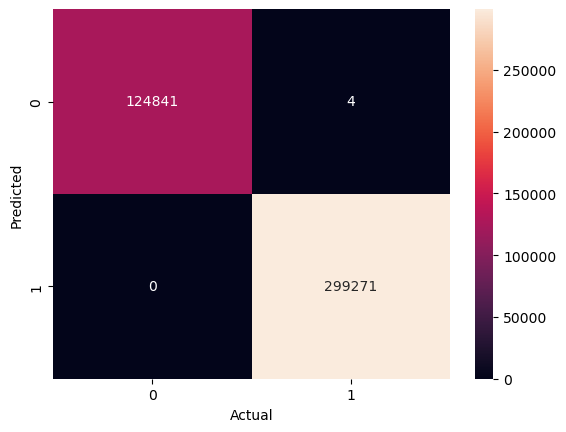

In [79]:
# Evaluation
y = y.flatten()
y_pred = y_pred.flatten()

print(classification_report(y, y_pred, digits=4))
print("ROC AUC score: ", roc_auc_score(y, y_pred))
print("Confusion matrix: ")
plt.figure()
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [81]:
rf.feature_importances_

array([0.01324294, 0.01625767, 0.01661686, 0.01112254, 0.01177892,
       0.0177484 , 0.0130537 , 0.01559007, 0.01951073, 0.00014727,
       0.0141199 , 0.01261508, 0.0119938 , 0.01063012, 0.01803473,
       0.01217077, 0.01188364, 0.01235749, 0.01396303, 0.01296609,
       0.01462871, 0.01494573, 0.01380708, 0.01251899, 0.01611237,
       0.01434308, 0.01224031, 0.01311481, 0.01185467, 0.0125208 ,
       0.01434387, 0.01362778, 0.01254811, 0.01551328, 0.01350533,
       0.02231466, 0.01971556, 0.01441284, 0.0158399 , 0.01522754,
       0.01582867, 0.01532081, 0.03547068, 0.01453484, 0.0149208 ,
       0.01569512, 0.01507414, 0.01508844, 0.01528658, 0.01529523,
       0.01550116, 0.01471645, 0.01515233, 0.0144086 , 0.01647567,
       0.01491515, 0.01431196, 0.01452244, 0.01590062, 0.01431484,
       0.0136931 , 0.01420162, 0.01822016, 0.01480894, 0.01535939,
       0.00317047, 0.00302554, 0.00252239, 0.0025851 , 0.01320913,
       0.01753047])

In [83]:
display(pd.DataFrame(rf.feature_importances_, columns=["Importance"], index=df_agg.columns).sort_values("Importance", ascending=False))

,Importance
time_spent_on_level_5,0.035471
action_count_on_level_group_5-12,0.022315
action_count_on_level_group_13-22,0.019716
map_click,0.019511
time_spent_on_level_group_13-22,0.018220
action_count_on_level_3,0.018035
object_click,0.017748
music_on_proportion,0.017530
navigate_click,0.016617
time_spent_on_level_17,0.016476


In [90]:
test_df = pd.read_csv('data/test.csv', dtype=dtypes)
test_df_agg = test_df.groupby('session_id').apply(feature_extraction_over_single_session)[df_agg.columns]

In [91]:
test_df_agg

,cutscene_click,person_click,navigate_click,observation_click,notification_click,object_click,object_hover,map_hover,map_click,checkpoint,...,time_spent_on_level_group_5-12,time_spent_on_level_group_13-22,average_clicking_distance,average_hover_duration,full_screen_time,full_screen_proportion,hq_on_time,hq_on_proportion,music_on_time,music_on_proportion
session_id,,,,,,,,,,,,,,,,,,,,,
20090109393214576,116.0,285.0,432.0,9.0,24.0,224.0,60.0,39.0,16.0,3.0,...,5231877.0,1024798.0,66091.320312,1790.323242,0.0,0.0,0.0,0.0,5169.591918,0.000792
20090312143683264,104.0,233.0,752.0,17.0,26.0,151.0,77.0,55.0,27.0,3.0,...,888227.0,1498404.0,92991.570312,1291.484863,0.0,0.0,0.0,0.0,1805.647568,0.000666
20090312331414616,96.0,218.0,335.0,8.0,26.0,96.0,67.0,55.0,18.0,3.0,...,523161.0,808373.0,89531.171875,1245.901611,0.0,0.0,0.0,0.0,1645.398964,0.001036


In [98]:
X_test = test_df_agg.values
y_pred = rf.predict(X_test)

from functools import reduce
session_ids = reduce(lambda x, y: x + [f'{y}_q{i}' for i in range(1, 19)], test_df_agg.index, [])
test_result = pd.DataFrame({
    'session_id': session_ids,
    'correct': y_pred.flatten()
})
test_result

,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090109393214576_q4,1
4,20090109393214576_q5,1
5,20090109393214576_q6,1
6,20090109393214576_q7,1
7,20090109393214576_q8,1
8,20090109393214576_q9,1
9,20090109393214576_q10,0
